#### Exploratory Data Analysis

In [ ]:
!pip install category_encoders==2.*
!pip install vaderSentiment

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
import pandas as pd

df = pd.read_csv('/content/kickstarter - complete.csv')

print(df.shape)
df

(999, 13)


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 0:20:50,45000,2013-01-12 0:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 4:24:11,5000,2012-03-17 3:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 1:00:00,19500,2015-07-04 8:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1005848496,The 1st Motion Tracking DIY Smart Home Securit...,Gadgets,Technology,USD,2016-12-31 3:54:32,25000,2016-11-01 2:54:32,58978,live,397,US,7235
995,1005862247,Veterans,Photography,Photography,USD,2012-08-15 6:00:00,5000,2012-07-09 5:39:06,5637,successful,87,US,5637
996,1005863674,MY VERY FIRST KICKSTARTER,Movie Theaters,Film & Video,USD,2014-08-12 20:08:35,6500,2014-07-13 20:08:35,27,failed,2,US,27
997,1005870420,This Song Is About You,Music,Music,USD,2014-07-11 23:35:00,40000,2014-06-11 23:35:00,0,failed,0,US,0


In [ ]:
print(df.columns)

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged'],
      dtype='object')


In [ ]:
# Convert date/time to engineer new feature
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(df['launched'])
df['length_of_campaign'] = (df['deadline'] - df['launched']).dt.days

In [ ]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,length_of_campaign
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,58
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,45
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,30
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,55
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,1005848496,The 1st Motion Tracking DIY Smart Home Securit...,Gadgets,Technology,USD,2016-12-31 03:54:32,25000,2016-11-01 02:54:32,58978,live,397,US,7235,60
995,1005862247,Veterans,Photography,Photography,USD,2012-08-15 06:00:00,5000,2012-07-09 05:39:06,5637,successful,87,US,5637,37
996,1005863674,MY VERY FIRST KICKSTARTER,Movie Theaters,Film & Video,USD,2014-08-12 20:08:35,6500,2014-07-13 20:08:35,27,failed,2,US,27,30
997,1005870420,This Song Is About You,Music,Music,USD,2014-07-11 23:35:00,40000,2014-06-11 23:35:00,0,failed,0,US,0,30


In [ ]:
# Using a pretrained neural network to encode title to numbers
# Adding numbers to column as sentiments
sentiments =[] 
analyzer = SentimentIntensityAnalyzer()
for sentence in df['name']:
  vs = analyzer.polarity_scores(sentence)
  sentiments.append(vs['compound'])
df['sentiments'] = sentiments

In [ ]:
# Defining success and fail for binary classification 
success = ['successful', 'live']
failed = ['failed',
            'canceled',
            'suspended',
            'undefined']

# Adding new binary values to its own column of project_succes
col = 'state'
conditions = [df[col].isin(success), df[col].isin(failed)]
choices = ['1', '0']
df['project_success'] = np.select(conditions, choices, default=np.nan)

In [ ]:
# Changing the datatypes of object columns to numerics

df['goal'] = (df['goal'].str.split()).apply(lambda x: float(x[0].replace(',', '')))
df['backers']= df['backers'].astype(str).astype(int)

In [ ]:
df1 = df.filter(['name', 'main_category', 'deadline', 'launched', 'goal', 'backers', 'length_of_campaign', 'project_success', 'sentiments'], axis=1)

In [ ]:
df1['main_category'] = df1['main_category'].replace('Publishing', 1)
df1['main_category'] = df1['main_category'].replace('Film & Video', 2)
df1['main_category'] = df1['main_category'].replace('Music', 3)
df1['main_category'] = df1['main_category'].replace('Food', 4)
df1['main_category'] = df1['main_category'].replace('Design', 5)
df1['main_category'] = df1['main_category'].replace('Crafts', 6)
df1['main_category'] = df1['main_category'].replace('Games', 7)
df1['main_category'] = df1['main_category'].replace('Comics', 8)
df1['main_category'] = df1['main_category'].replace('Fashion', 9)
df1['main_category'] = df1['main_category'].replace('Theatre', 10)
df1['main_category'] = df1['main_category'].replace('Art', 11)
df1['main_category'] = df1['main_category'].replace('Photography', 12)
df1['main_category'] = df1['main_category'].replace('Technology', 13)
df1['main_category'] = df1['main_category'].replace('Dance', 14)
df1['main_category'] = df1['main_category'].replace('Journalism', 15)

In [ ]:
df1

,name,main_category,deadline,launched,goal,backers,length_of_campaign,project_success,sentiments
0,The Songs of Adelaide & Abullah,1,2015-10-09 11:36:00,2015-08-11 12:12:28,1000.0,0,58,0,0.0000
1,Where is Hank?,2,2013-02-26 00:20:50,2013-01-12 00:20:50,45000.0,3,45,0,0.0000
2,ToshiCapital Rekordz Needs Help to Complete Album,3,2012-04-16 04:24:11,2012-03-17 03:24:11,5000.0,1,30,0,0.4019
3,Community Film Project: The Art of Neighborhoo...,2,2015-08-29 01:00:00,2015-07-04 08:35:03,19500.0,14,55,0,0.0000
4,Monarch Espresso Bar,4,2016-04-01 13:38:27,2016-02-26 13:38:27,50000.0,224,35,1,0.0000
...,...,...,...,...,...,...,...,...,...
994,The 1st Motion Tracking DIY Smart Home Securit...,13,2016-12-31 03:54:32,2016-11-01 02:54:32,25000.0,397,60,1,0.6249
995,Veterans,12,2012-08-15 06:00:00,2012-07-09 05:39:06,5000.0,87,37,1,0.0000
996,MY VERY FIRST KICKSTARTER,2,2014-08-12 20:08:35,2014-07-13 20:08:35,6500.0,2,30,0,0.0000
997,This Song Is About You,3,2014-07-11 23:35:00,2014-06-11 23:35:00,40000.0,0,30,0,0.0000


#### Baseline

In [ ]:
df2 = df1[['goal', 'main_category', 'backers', 'length_of_campaign', 'sentiments', 'project_success']]

In [ ]:
df2

,goal,main_category,backers,length_of_campaign,sentiments,project_success
0,1000.0,1,0,58,0.0000,0
1,45000.0,2,3,45,0.0000,0
2,5000.0,3,1,30,0.4019,0
3,19500.0,2,14,55,0.0000,0
4,50000.0,4,224,35,0.0000,1
...,...,...,...,...,...,...
994,25000.0,13,397,60,0.6249,1
995,5000.0,12,87,37,0.0000,1
996,6500.0,2,2,30,0.0000,0
997,40000.0,3,0,30,0.0000,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Split train into train & val
from sklearn.model_selection import train_test_split
train, val = train_test_split(df1, train_size=0.80, test_size=0.20, 
                              stratify=df2['project_success'], random_state=42)

In [ ]:
# Baseline
target = 'project_success'
y_train = train[target]
y_train.value_counts(normalize=True)

0    0.604506
1    0.395494
Name: project_success, dtype: float64

#### Logistic Regression

In [ ]:
# Arrange data into X features matrix and y target vector
features = ['goal', 'main_category', 'backers', 'length_of_campaign', 'sentiments']
target = 'project_success'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
# Check shape before encoding
X_train.shape, X_val.shape

((799, 5), (200, 5))

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [ ]:
# Check shape after encoding
X_train_encoded.shape, X_val_encoded.shape

((799, 19), (200, 19))

In [ ]:
X_train_encoded.head()

,goal,main_category_4,main_category_11,main_category_5,main_category_9,main_category_13,main_category_1,main_category_2,main_category_Theater,main_category_3,main_category_6,main_category_7,main_category_8,main_category_12,main_category_14,main_category_15,backers,length_of_campaign,sentiments
772,50000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,30,0.0000
786,1300.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4,16,0.4019
339,15000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,35,0.0000
771,9500.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,38,0.4019
39,40000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,855,30,0.0000


In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [ ]:
X_val_imputed[:5]  # Slice to the first 5 observations

array([[ 8.500e+02,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00,
         0.000e+00,  2.400e+01,  3.000e+01,  0.000e+00],
       [ 4.000e+03,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  1.900e+01,  4.900e+01,  0.000e+00],
       [ 2.500e+04,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  1.600e+01,  3.000e+01, -1.779e-01],
       [ 5.000e+03,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  1.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.00

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [ ]:
X_val_scaled[:5]

array([[-0.18455046, -0.27453619, -0.32657036, -0.27189103, -0.23554653,
        -0.28749926, -0.31229389, -0.4787805 , -0.16826773, -0.42450771,
        -0.13832083, -0.29508445, -0.17597654, -0.17597654,  8.8825672 ,
        -0.09401268, -0.22137588, -0.27938589, -0.26426847],
       [-0.16709395, -0.27453619,  3.06212726, -0.27189103, -0.23554653,
        -0.28749926, -0.31229389, -0.4787805 , -0.16826773, -0.42450771,
        -0.13832083, -0.29508445, -0.17597654, -0.17597654, -0.11258007,
        -0.09401268, -0.23594536,  1.31811212, -0.26426847],
       [-0.05071724, -0.27453619, -0.32657036, -0.27189103, -0.23554653,
        -0.28749926, -0.31229389,  2.08863977, -0.16826773, -0.42450771,
        -0.13832083, -0.29508445, -0.17597654, -0.17597654, -0.11258007,
        -0.09401268, -0.24468705, -0.27938589, -0.96041806],
       [-0.1615522 , -0.27453619, -0.32657036, -0.27189103, -0.23554653,
        -0.28749926, -0.31229389,  2.08863977, -0.16826773, -0.42450771,
        -0.138

In [ ]:
# Fit our model!
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [ ]:
# Predicting score
model.score(X_val_scaled, y_val)

0.795

#### Random Forest

In [ ]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.86


#### Permutation Importances

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, 
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train);

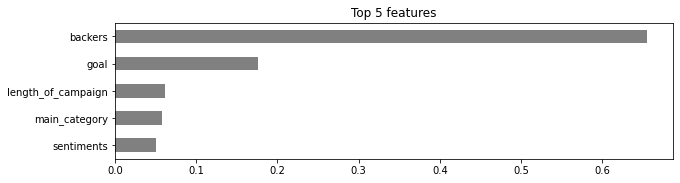

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 5
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');